In [1]:
import numpy as np
import pandas as pd
import pickle
import cv2, PIL, glob, pathlib
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import backend as K
from tensorflow.keras.optimizers import SGD,RMSprop,Adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
from subprocess import check_output
import tensorflow as tf
import seaborn as sns
import warnings
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
warnings.filterwarnings('ignore')


In [2]:
print(check_output(["ls", "../input/eyediseasedata/dataset"]).decode("utf8"))
print(os.listdir("../input/eyediseasedata/dataset"))

cataract_eye
diabetic_retinopathy_eye
glaucoma_eye
normal_eye

['glaucoma_eye', 'normal_eye', 'diabetic_retinopathy_eye', 'cataract_eye']


In [3]:
# generating dataset from directory

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = '../input/eyediseasedata/dataset',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)


Found 4640 files belonging to 4 classes.


In [4]:
labels = np.concatenate([y for x,y in data], axis=0)

In [5]:
values = pd.value_counts(labels)
values = values.sort_index()

In [7]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = cataract_eye, 1 = diabetic_retinopathy_eye, 2 = glaucoma_eye, 3 = normal_eye, 

In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
batch[0].shape

(64, 224, 224, 3)

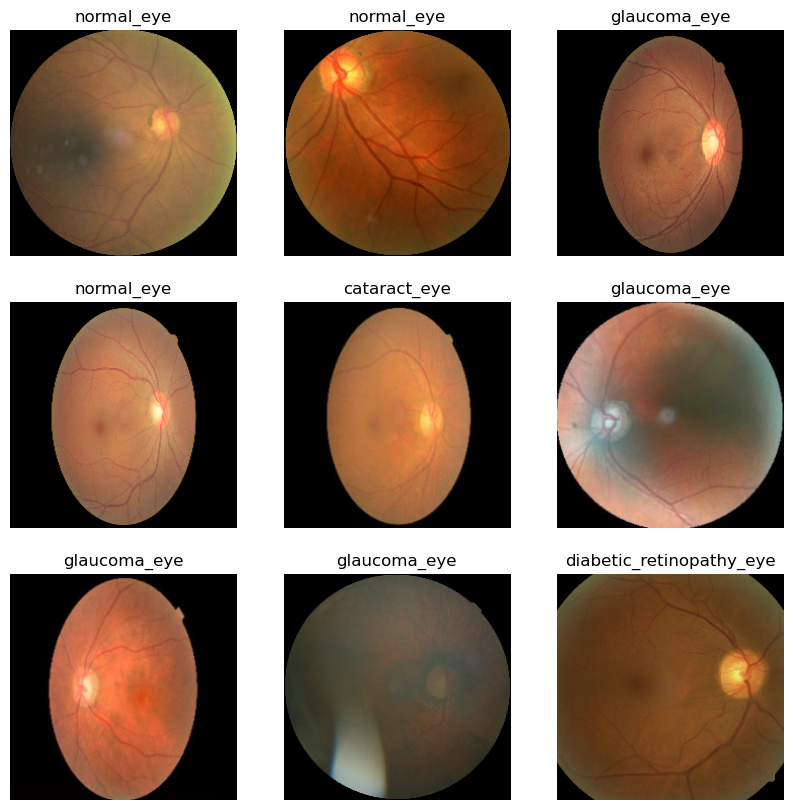

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
data = data.map(lambda x, y: (x/255, y))

In [14]:
sample = data.as_numpy_iterator().next()

In [15]:
print(sample[0].min())
print(sample[0].max())

0.0
1.0


In [16]:
print("Total number of batchs = ",len(data))

Total number of batchs =  73


In [17]:
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [18]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [19]:
print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
len(train) + len(val) + len(test)

# train batchs = 52, # validate batchs = 14, # test batch = 7


73

In [20]:
test_iter = test.as_numpy_iterator()

In [21]:
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [22]:
y_true = test_set['labels']


In [23]:
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,Average

In [24]:
model_1=load_model('../input/models/model/efficient_best_.hdf5')

In [25]:
model_1=Model(inputs=model_1.inputs,
             outputs=model_1.outputs,
             name='Effiecent')

In [26]:
model_2=load_model('../input/models/model/inception_best.hdf5')

In [27]:
model_2=load_model('../input/models/model/inception_best.hdf5')

In [28]:
model_2=Model(inputs=model_2.inputs,
             outputs=model_2.outputs,
             name='Inception')

In [29]:
model_3=load_model('../input/models/model/densenet_best_.hdf5')

In [30]:
model_3=Model(inputs=model_3.inputs,
             outputs=model_3.outputs,
             name='Dense')

In [31]:
models=[model_1,model_2,model_3]
model_input=Input(shape=(224,224,3))
model_outputs=[model(model_input) for model in models]

In [32]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self,w1,w2,w3,**kwargs):
        super(WeightedAverageLayer,self).__init__(**kwargs)
        self.w1=w1
        self.w2=w2
        self.w3=w3
    
    def call(self, inputs):
        return self.w1*inputs[0] + self.w2*inputs[1] + self.w3*inputs[2]

In [33]:
ensemble_output= WeightedAverageLayer(0.3, 0.4 ,0.3)(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [34]:
ensemble_model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
ehistory = ensemble_model.fit(
    train,
    validation_data=val,
    epochs=50
    )

Epoch 1/50


2023-05-08 19:19:46.865252: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/Effiecent/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


52/52 [==============================] - 223s 2s/step - loss: 3.7976 - accuracy: 0.9411 - val_loss: 1.7684 - val_accuracy: 0.8493
Epoch 2/50
52/52 [==============================] - 94s 2s/step - loss: 0.9838 - accuracy: 0.9522 - val_loss: 0.6987 - val_accuracy: 0.9018
Epoch 3/50
52/52 [==============================] - 95s 2s/step - loss: 0.4255 - accuracy: 0.9814 - val_loss: 0.4445 - val_accuracy: 0.9330
Epoch 4/50
52/52 [==============================] - 94s 2s/step - loss: 0.3068 - accuracy: 0.9760 - val_loss: 0.4863 - val_accuracy: 0.8839
Epoch 5/50
52/52 [==============================] - 93s 2s/step - loss: 0.2582 - accuracy: 0.9784 - val_loss: 0.4003 - val_accuracy: 0.9252
Epoch 6/50
52/52 [==============================] - 94s 2s/step - loss: 0.2296 - accuracy: 0.9847 - val_loss: 0.3842 - val_accuracy: 0.9185
Epoch 7/50
52/52 [==============================] - 93s 2s/step - loss: 0.2157 - accuracy: 0.9859 - val_loss: 0.3635 - val_accuracy: 0.9074
Epoch 8/50
52/52 [============

In [36]:
ensemble_model.evaluate(test)

7/7 [==============================] - 45s 474ms/step - loss: 0.2903 - accuracy: 0.9279


[0.2903216481208801, 0.9278846383094788]

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
# !pip install visualkeras
# import visualkeras

In [38]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

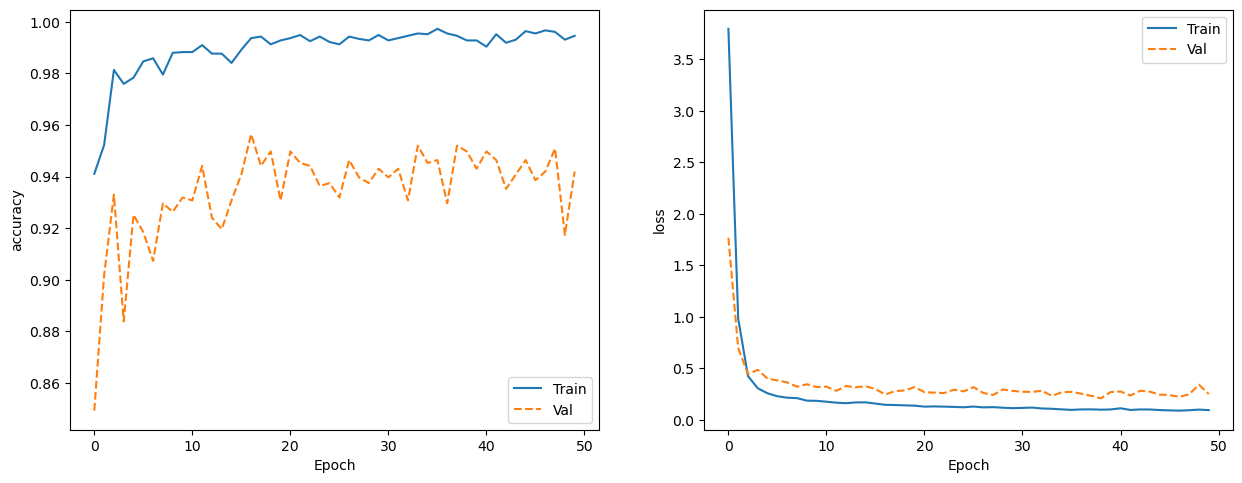

In [39]:
plot_his(ehistory)

In [40]:
y_pred = np.argmax(ensemble_model.predict(test_set['images']), 1)

13/13 [==============================] - 9s 170ms/step


In [41]:
print(classification_report(y_true, y_pred, target_names = class_names))

                          precision    recall  f1-score   support

            cataract_eye       0.99      0.85      0.92        89
diabetic_retinopathy_eye       1.00      1.00      1.00       114
            glaucoma_eye       0.90      0.90      0.90        94
              normal_eye       0.86      0.95      0.90       119

                accuracy                           0.93       416
               macro avg       0.94      0.93      0.93       416
            weighted avg       0.94      0.93      0.93       416



Text(0.5, 1.0, 'Confusion Matrix')

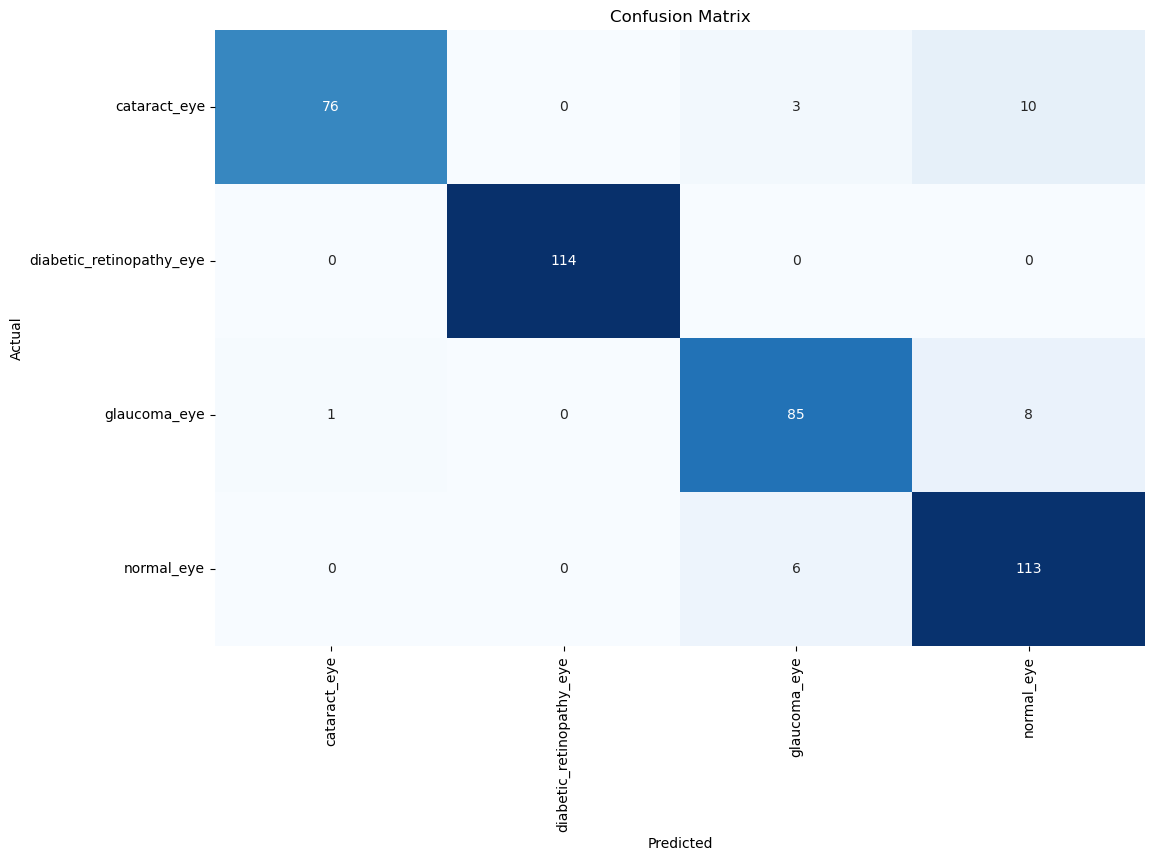

In [42]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names, rotation=90)
plt.yticks(np.arange(4)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [43]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Effiecent (Functional)         (None, 4)            12367667    ['input_1[0][0]']                
                                                                                                  
 Inception (Functional)         (None, 4)            35864484    ['input_1[0][0]']                
                                                                                                  
 Dense (Functional)             (None, 4)            10350276    ['input_1[0][0]']            

In [1]:
#Model Save
# ensemble_model.save_weights('enmodel_weights.h5')
# ensemble_model.save('enmodel_keras.h5')